In [27]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l


In [28]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [29]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [30]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.11856 sec'

In [31]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [32]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

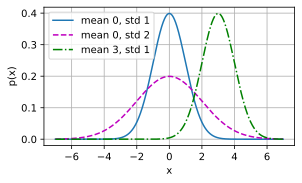

In [33]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [34]:
import d2l
print(d2l.__file__)  # 输出路径应包含 "d2l-pytorch" 字样

D:\py\Python3\lib\site-packages\d2l\__init__.py


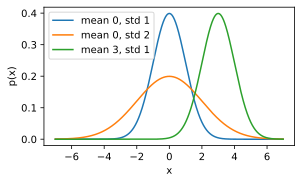

In [35]:
import torch
import matplotlib.pyplot as plt

def normal(x, mu, sigma):
    # 将 mu 和 sigma 转换为与 x 同类型的张量（避免类型不匹配）
    mu = torch.tensor(mu, dtype=x.dtype)
    sigma = torch.tensor(sigma, dtype=x.dtype)
    p = 1 / torch.sqrt(2 * torch.pi * sigma**2)
    return p * torch.exp(-(x - mu)**2 / (2 * sigma**2))

# 生成 x 轴数据（PyTorch 张量）
x = torch.arange(-7, 7, 0.01, dtype=torch.float32)
params = [(0, 1), (0, 2), (3, 1)]  # (均值, 标准差)

# 绘制曲线
plt.figure(figsize=(4.5, 2.5))
for mu, sigma in params:
    y = normal(x, mu, sigma)
    plt.plot(x.numpy(), y.numpy(), label=f'mean {mu}, std {sigma}')  # 转换为 numpy 数组绘图
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

In [36]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [37]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [38]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.1935, 1.0146]) 
label: tensor([1.1296])
features: tensor([-1.6570,  1.2995]) 
label: tensor([-3.5331])


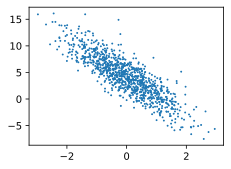

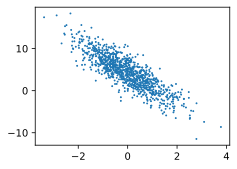

In [39]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [40]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [41]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.2463,  0.1611],
        [-0.9193,  1.3927],
        [ 1.0702, -0.9994],
        [ 1.3878,  0.1448],
        [ 0.1007,  0.0799],
        [ 1.8894,  0.3941],
        [ 0.7369,  2.2535],
        [ 0.4580,  0.9712],
        [-0.7356, -0.9601],
        [-0.1808, -0.0664]]) 
 tensor([[ 1.1636],
        [-2.3841],
        [ 9.7339],
        [ 6.4883],
        [ 4.1469],
        [ 6.6281],
        [-1.9857],
        [ 1.8133],
        [ 5.9776],
        [ 4.0719]])
tensor([[ 1.5319,  0.4888],
        [ 0.4858,  0.6588],
        [ 0.2770, -1.4433],
        [ 0.3741,  1.8251],
        [-1.9523, -1.7311],
        [ 1.1171,  0.5212],
        [-0.3758, -1.9711],
        [-0.2447,  0.3697],
        [-1.9421, -1.0493],
        [ 0.8210, -0.1153]]) 
 tensor([[ 5.6053],
        [ 2.9073],
        [ 9.6632],
        [-1.2644],
        [ 6.1735],
        [ 4.6571],
        [10.1485],
        [ 2.4581],
        [ 3.8995],
        [ 6.2464]])


In [42]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [43]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [44]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [45]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [46]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037421
epoch 2, loss 0.000129
epoch 3, loss 0.000047
epoch 1, loss 0.024044
epoch 2, loss 0.000088
epoch 3, loss 0.000050


In [47]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 1.3471e-05, -1.7858e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
w的估计误差: tensor([-8.3661e-04,  6.8426e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


In [50]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [51]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [52]:
next(iter(data_iter))


[tensor([[ 1.0107,  1.6700],
         [ 0.2618, -1.8859],
         [ 0.4312,  1.5970],
         [ 0.1578,  2.4401],
         [-1.7448,  0.5680],
         [ 1.8678, -0.3467],
         [ 0.2358, -0.5008],
         [ 0.2900, -0.2505],
         [ 1.5942,  0.9912],
         [ 2.4609, -0.3916]]),
 tensor([[ 0.5348],
         [11.1485],
         [-0.3588],
         [-3.7861],
         [-1.2089],
         [ 9.1177],
         [ 6.3577],
         [ 5.6188],
         [ 4.0044],
         [10.4458]])]

In [53]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))


In [54]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.])

In [55]:
loss = nn.MSELoss()


In [56]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)


In [57]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000325
epoch 2, loss 0.000104
epoch 3, loss 0.000104


In [58]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


w的估计误差： tensor([-0.0001,  0.0011])
b的估计误差： tensor([-0.0006])


In [59]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()


In [60]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)


100%|██████████| 26421880/26421880 [00:06<00:00, 3887523.56it/s]


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 203342.11it/s]


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1312821.09it/s]


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [61]:
len(mnist_train), len(mnist_test)


(60000, 10000)

In [62]:
mnist_train[0][0].shape


torch.Size([1, 28, 28])

In [63]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [64]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


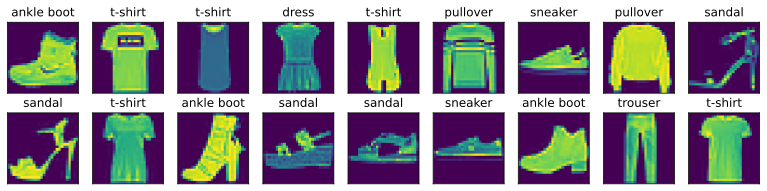

In [65]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));


In [66]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())


In [67]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'


'6.84 sec'

In [68]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


In [69]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [70]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


In [71]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [72]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [73]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制


In [74]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)


(tensor([[0.1020, 0.0411, 0.0343, 0.0783, 0.7443],
         [0.3512, 0.2286, 0.1732, 0.0489, 0.1981]]),
 tensor([1.0000, 1.0000]))

In [75]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


In [76]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]


tensor([0.1000, 0.5000])

In [77]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)


tensor([2.3026, 0.6931])

In [78]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


In [79]:
accuracy(y_hat, y) / len(y)


0.5

In [81]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [82]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [83]:
evaluate_accuracy(net, test_iter)


0.0994

In [84]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [85]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [86]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [87]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)


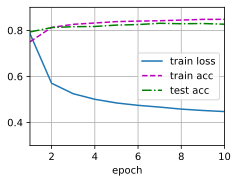

In [88]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


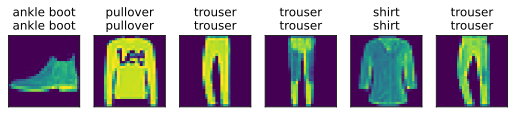

In [89]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)


In [90]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


In [91]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);


In [92]:
loss = nn.CrossEntropyLoss(reduction='none')


In [93]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)


In [98]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

# ------------------------- 辅助函数：动态绘图（Animator） -------------------------
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用 lambda 函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = [], [], fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# ------------------------- 辅助函数：单轮训练（train_epoch_ch3） -------------------------
def train_epoch_ch3(net, train_iter, loss, trainer):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, nn.Module):
        net.train()
    # 训练损失总和、训练准确率总和、样本数
    train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 使用 PyTorch 内置的优化器和损失函数
        trainer.zero_grad()
        l.backward()
        trainer.step()
        # 统计指标
        train_loss_sum += l.item() * y.numel()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.numel()
    return train_loss_sum / n, train_acc_sum / n

# ------------------------- 辅助函数：评估准确率（evaluate_accuracy） -------------------------
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add((net(X).argmax(dim=1) == y).sum().item(), y.numel())
    return metric[0] / metric[1]

# ------------------------- 辅助类：累加器（Accumulator） -------------------------
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * n

    def __getitem__(self, idx):
        return self.data[idx]

# ------------------------- 核心训练函数：train_ch3 -------------------------
def train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, trainer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x28 and 784x256)

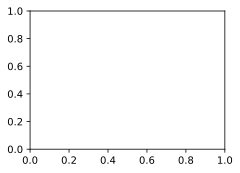

In [100]:
# 假设你已经定义了模型、训练/测试数据迭代器、损失函数和优化器
net = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))  # 示例模型（如MNIST分类）
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)  # 优化器
num_epochs = 10

# 调用训练函数
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x28 and 784x256)

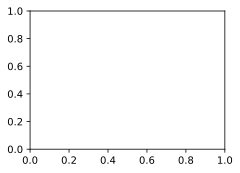

In [101]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
